<a href="https://colab.research.google.com/github/CesarC15/projetoML/blob/main/src/deteccao_anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup Infraestrutura e Dados**

In [24]:
pip install kagglehub[pandas-datasets] ydata-profiling imbalanced-learn seaborn matplotlib -q

In [25]:
import kagglehub
import pandas as pd
import os
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
#Aquisição de Dados
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
file_path = os.path.join(path, 'creditcard.csv')

Using Colab cache for faster access to the 'creditcardfraud' dataset.


In [27]:
df = pd.read_csv(file_path)

print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [ ]:
#Análise Exploratória (EDA)
profile = ProfileReport(df, title="Profiling Report")
profile.to_notebook_iframe()

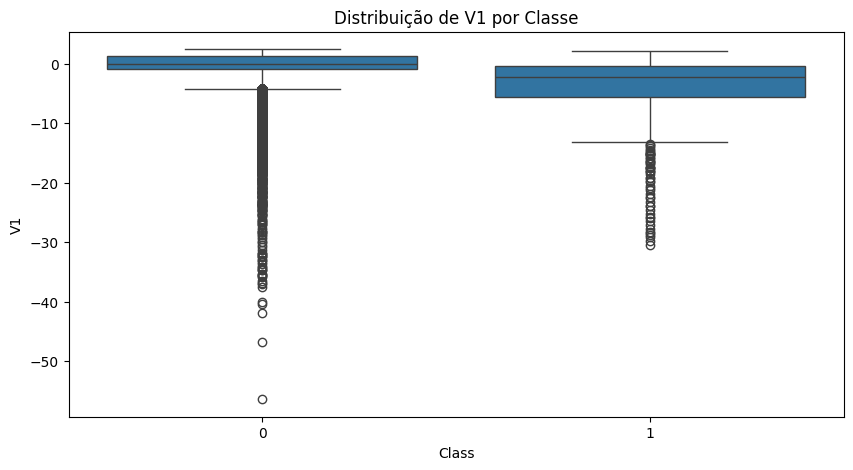

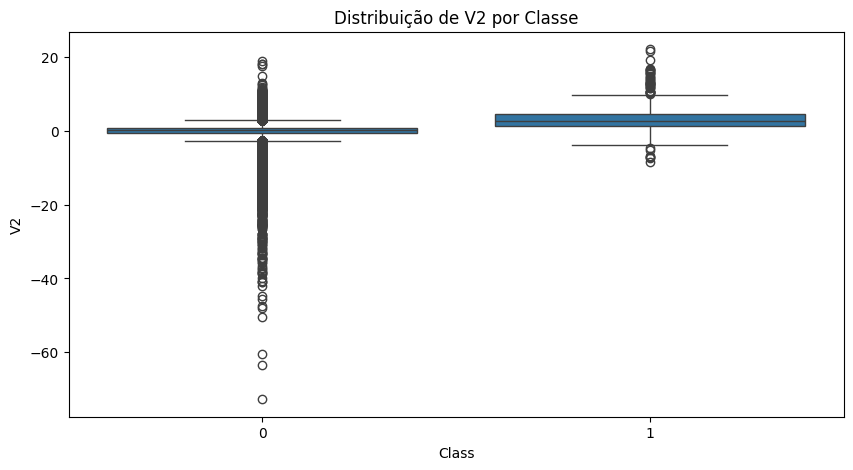

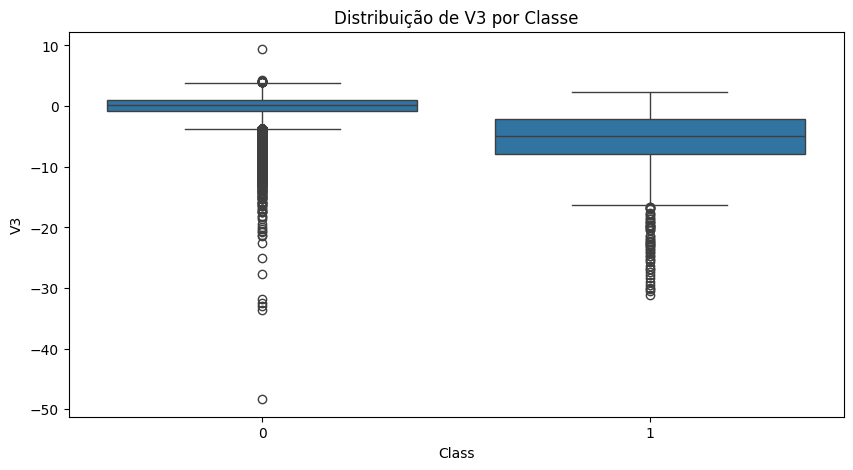

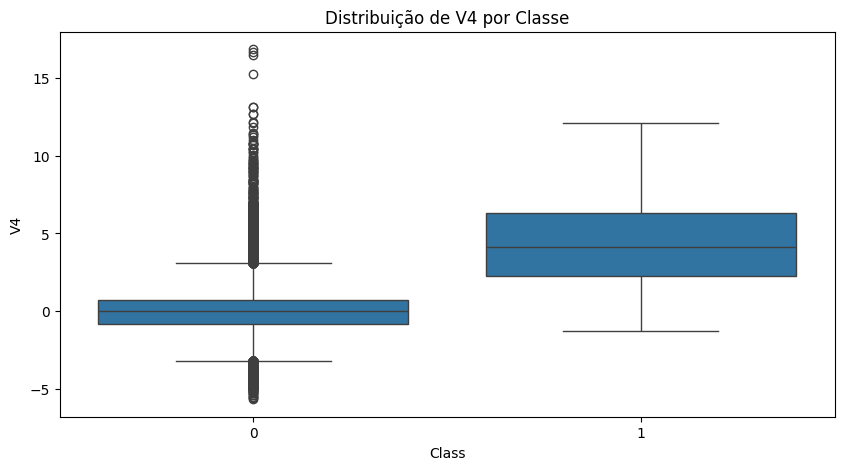

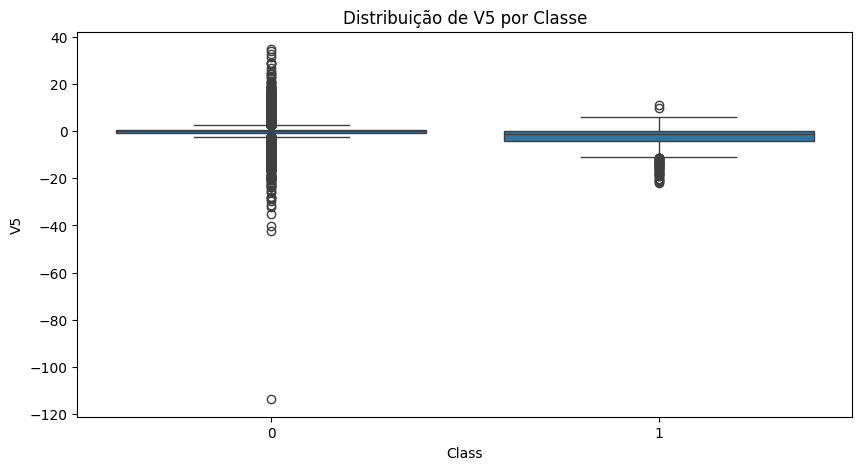

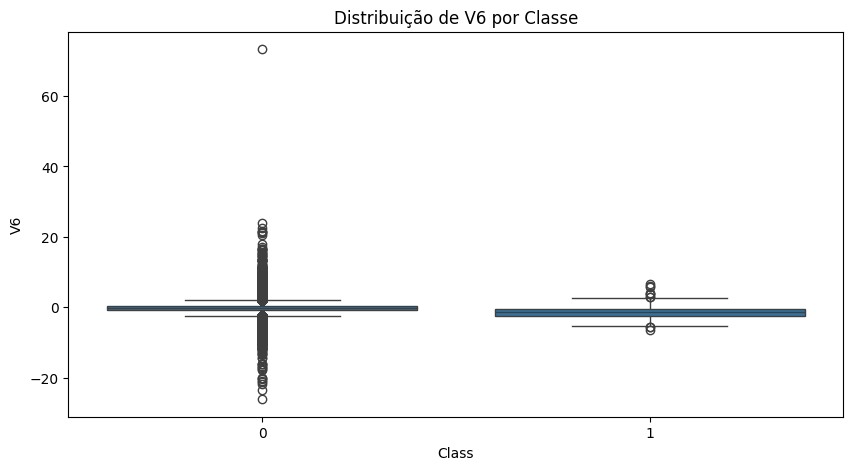

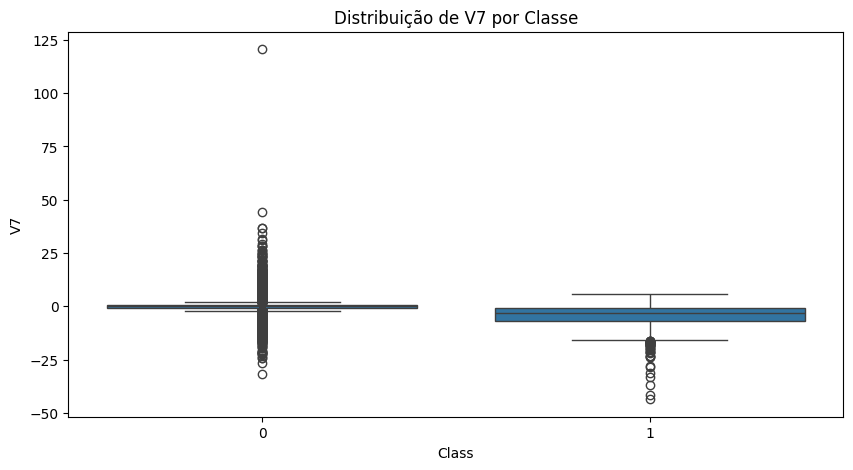

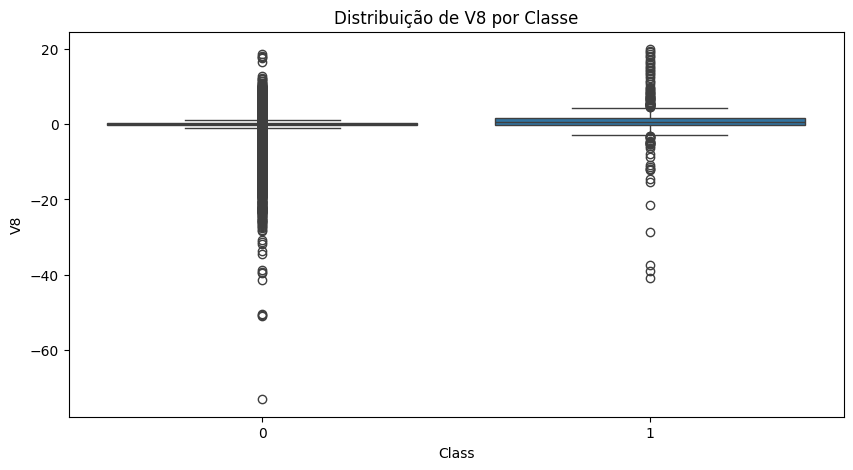

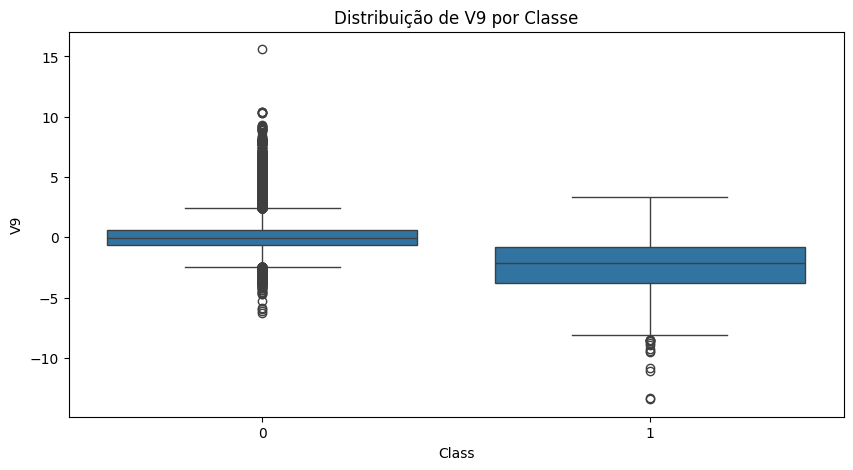

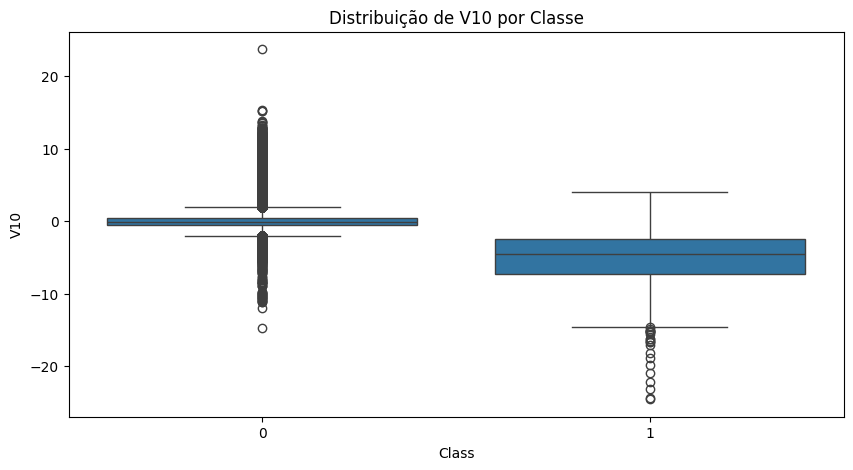

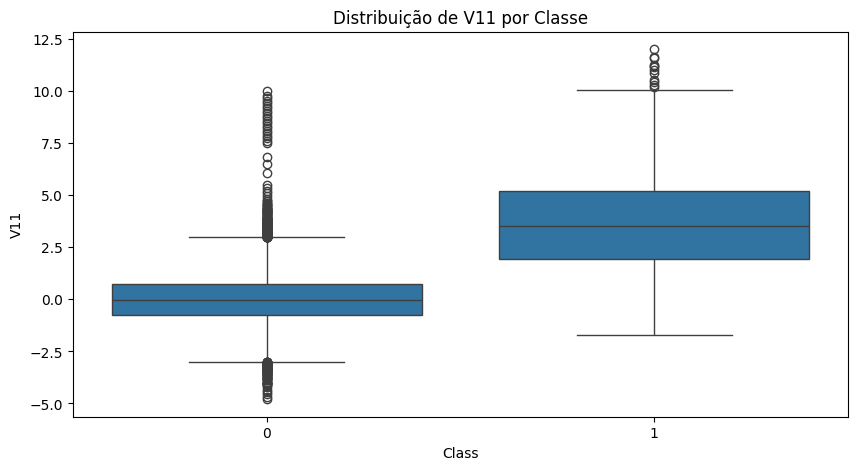

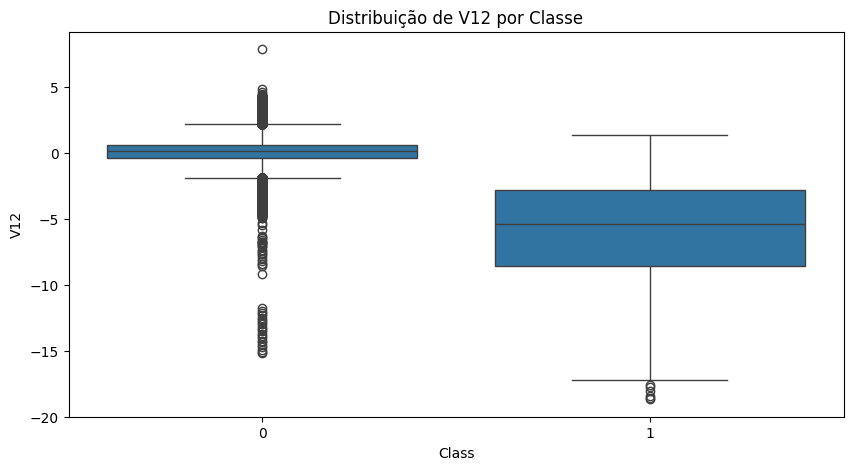

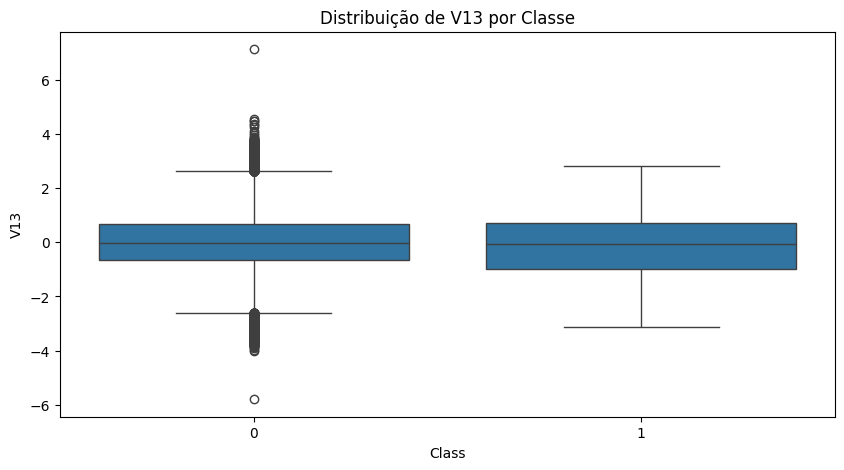

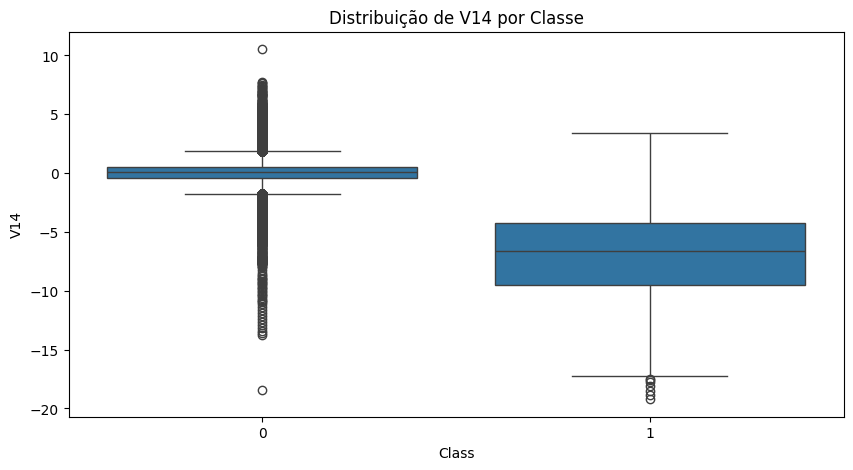

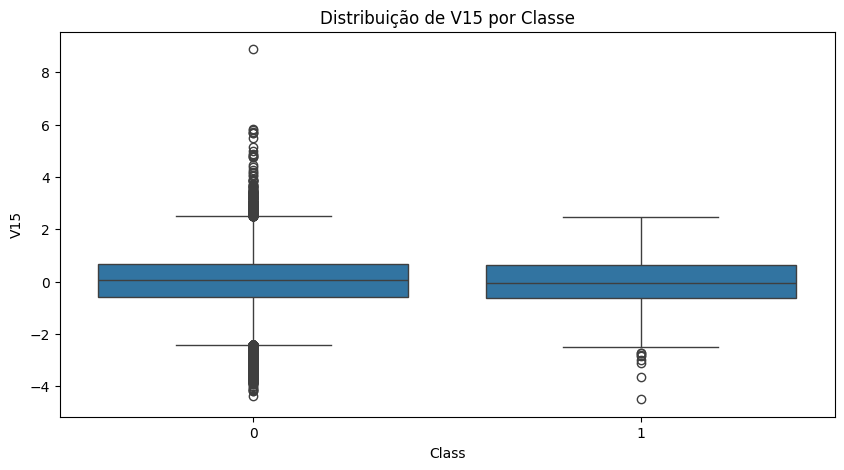

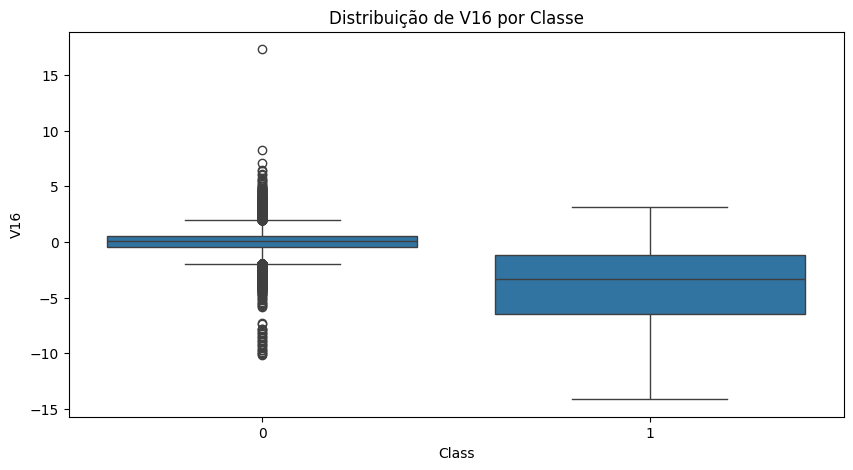

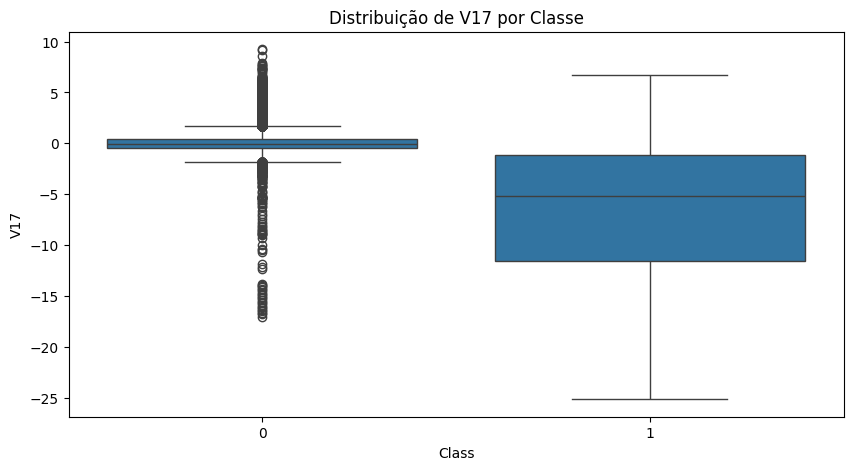

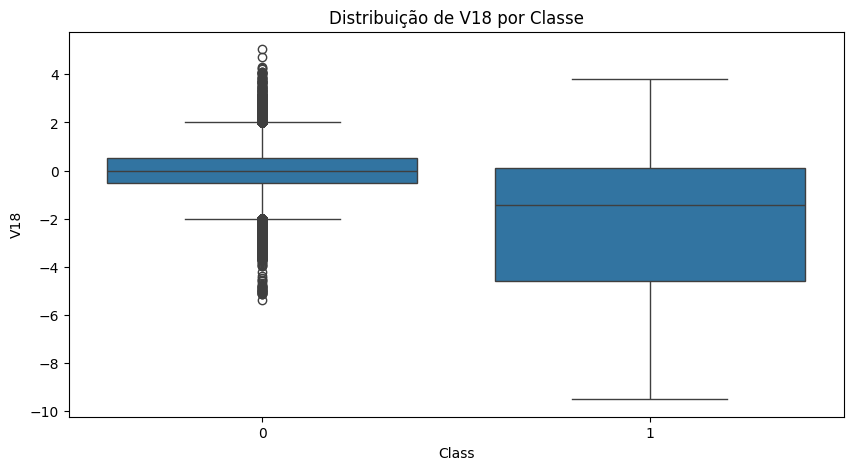

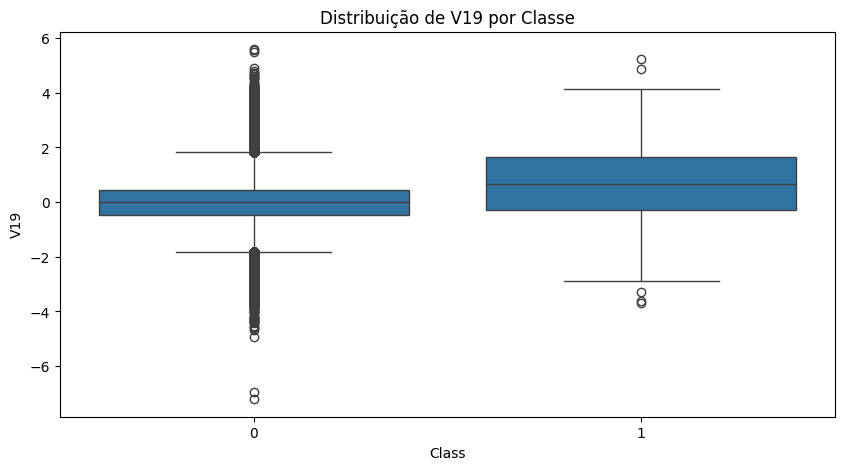

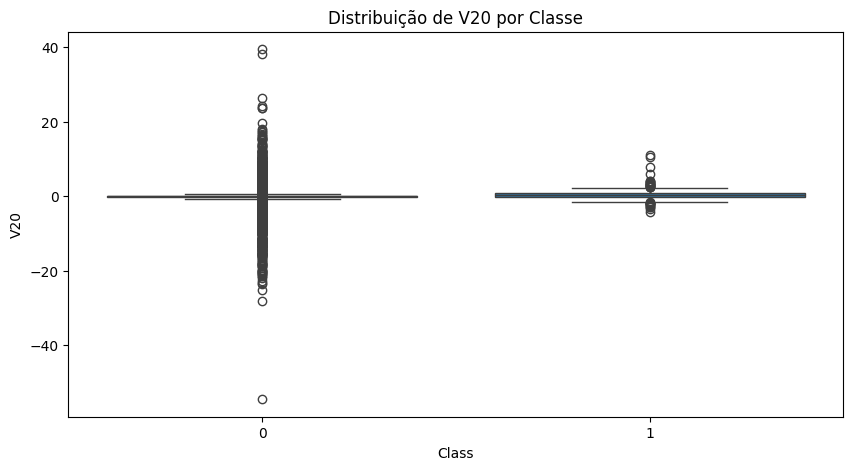

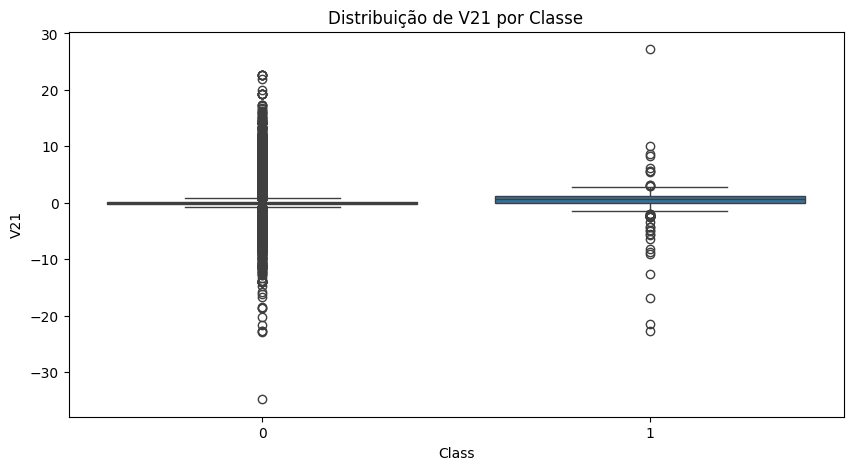

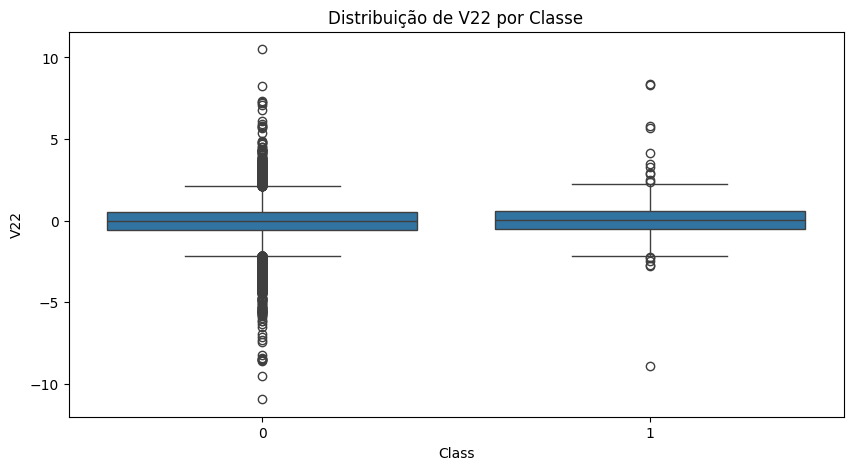

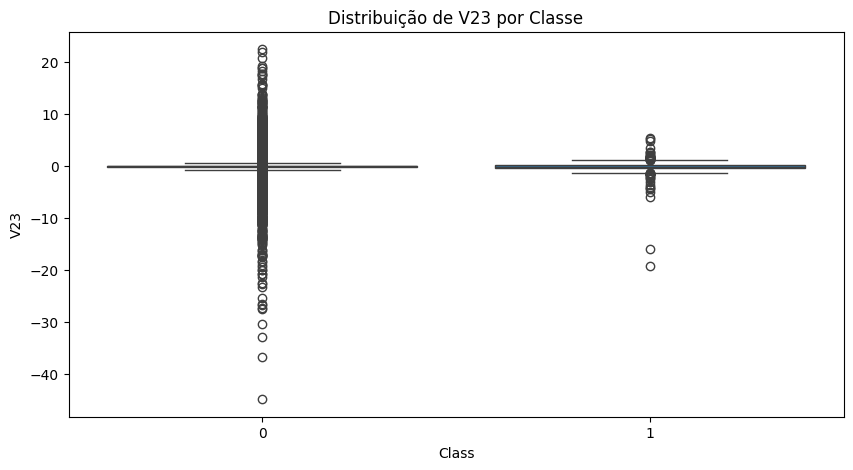

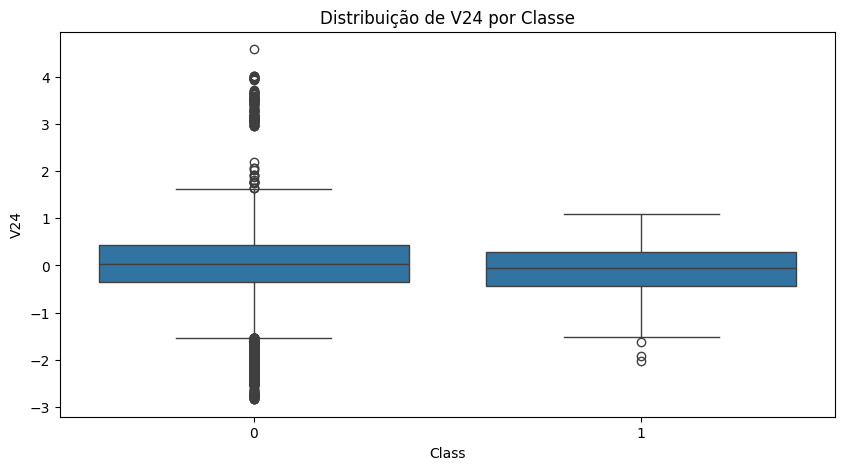

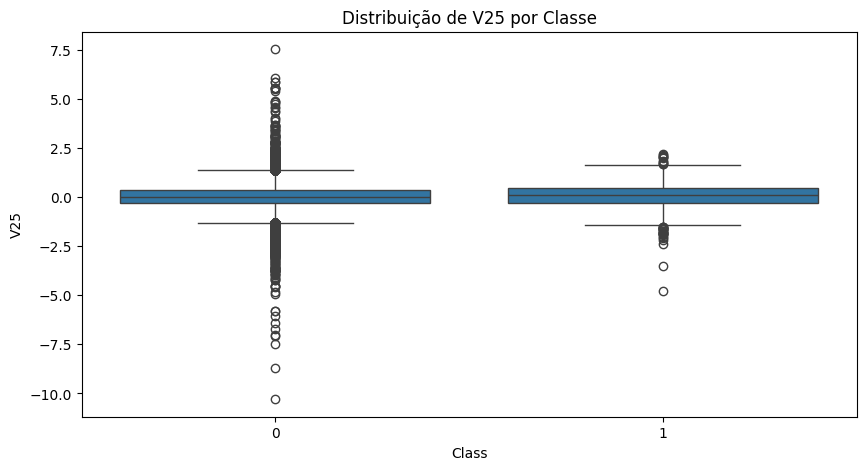

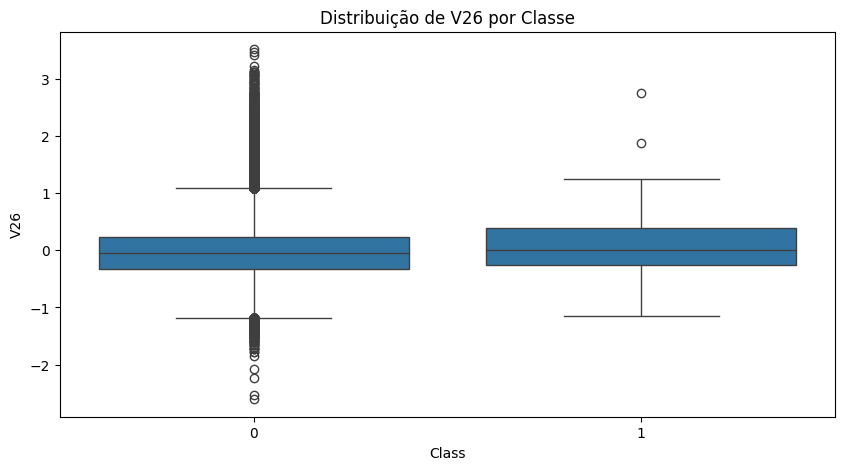

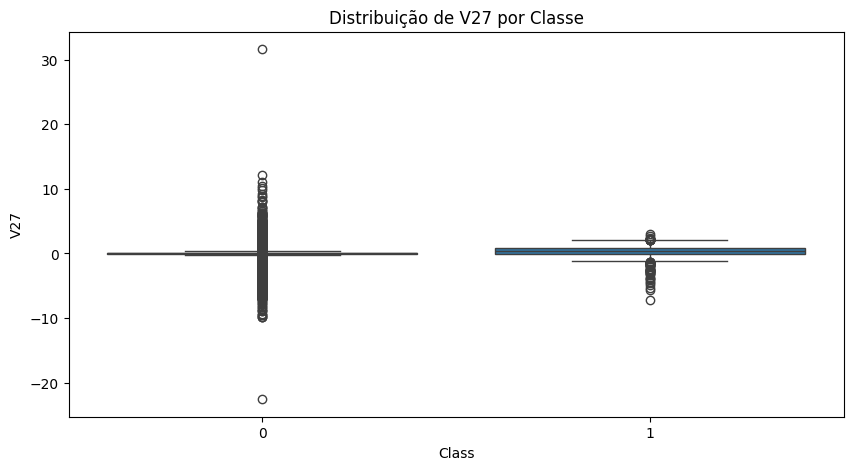

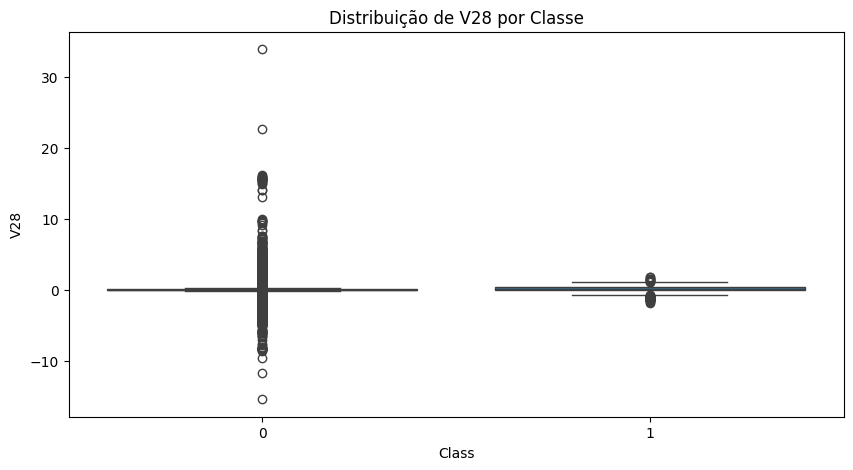

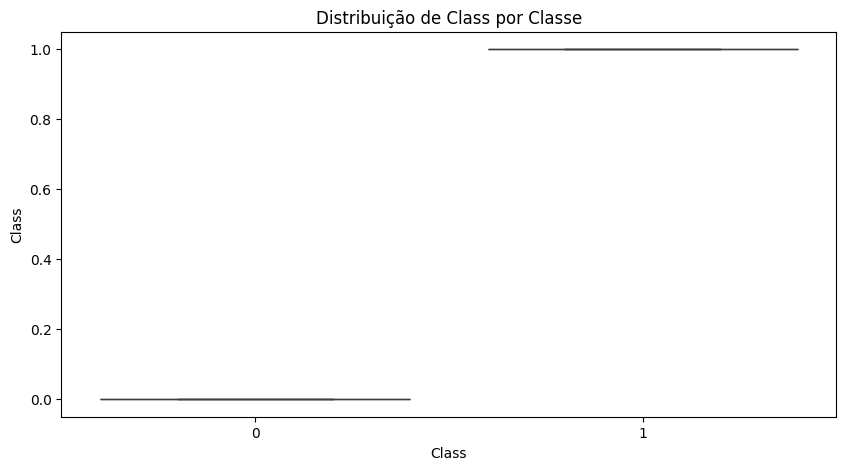

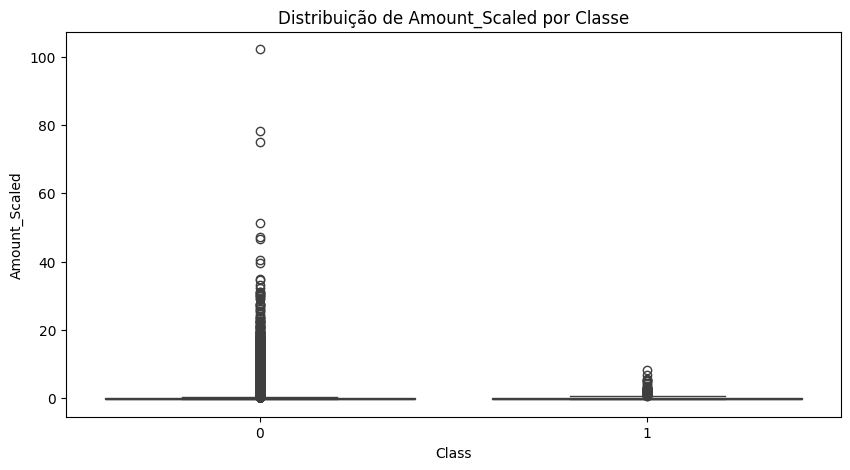

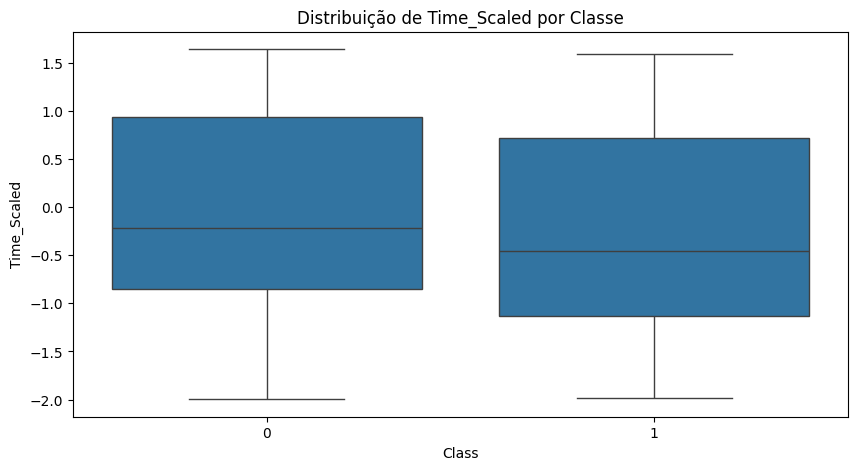

In [ ]:
#Tá horrível, muito outlier, não da para saber nada com isso
#TODO: mudar
for column in df:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Class', y=column, data=df)
    plt.title(f'Distribuição de {column} por Classe')
    plt.show()

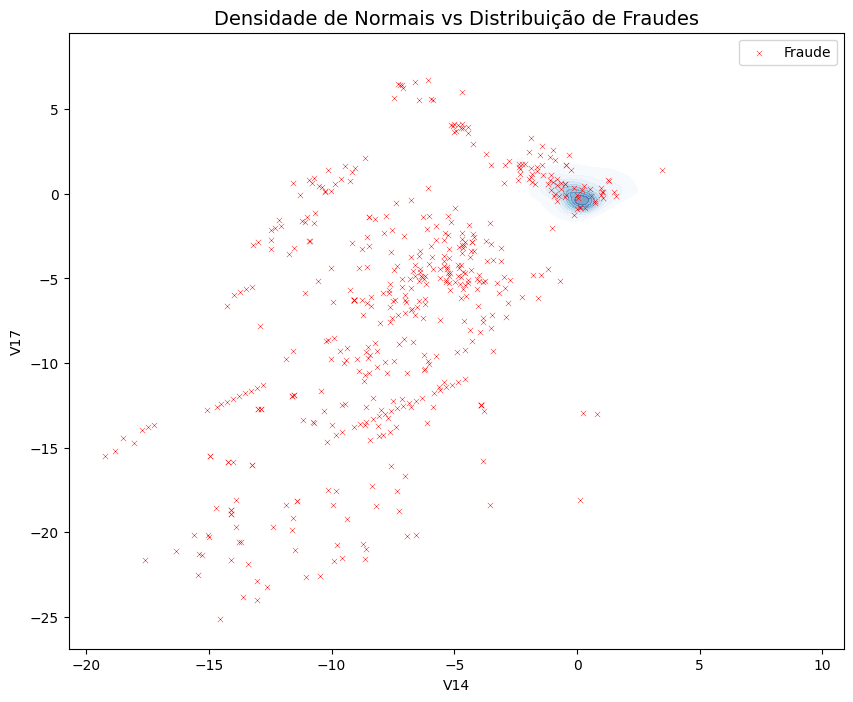

In [31]:
plt.figure(figsize=(10, 8))

sns.kdeplot(
    data=df[df['Class'] == 0],
    x='V14', y='V17',
    cmap="Blues", fill=True, thresh=0.05, alpha=0.5, label='Normal'
)

sns.scatterplot(
    data=df[df['Class'] == 1],
    x='V14', y='V17',
    color='red', s=15, marker='x', label='Fraude'
)

plt.title('Densidade de Normais vs Distribuição de Fraudes', fontsize=14)
plt.legend()
plt.show()

In [ ]:
#Pré-processamento
#----------------#
#Tratamento de Nulos e Duplicatas
print(f"Tamanho com duplicata: {df.shape[0]}")
df.drop_duplicates(inplace=True)
print(f"Tamanho sem duplicata: {df.shape[0]}")

print(f"Número de nulos: {df.isnull().sum().sum()}")

#Scaling e Encoding
##V1 até V28 já passaram por transformação de PCA, precisa normalizar só Time e Ammount
#TODO: Acho que é bom colocar depois no relatório sobre PCA
scaler = StandardScaler()

df["Amount_Scaled"] = scaler.fit_transform(df[["Amount"]])
df["Time_Scaled"] = scaler.fit_transform(df[["Time"]])
df.drop(columns=["Time", "Amount"], axis=1, inplace=True)

print(df[["Amount_Scaled", "Time_Scaled"]].head())

Tamanho com duplicata: 284807
Tamanho sem duplicata: 283726
Número de nulos: 0
   Amount_Scaled  Time_Scaled
0       0.244200    -1.996823
1      -0.342584    -1.996823
2       1.158900    -1.996802
3       0.139886    -1.996802
4      -0.073813    -1.996781


In [ ]:
#Split de Dados (Estratégia de Validação)
X = df.drop("Class", axis=1)
y = df["Class"]

#Proporção igual de fraude para cada conjunto - Deve ser melhor para LOF/KNN e isolation forest
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Amostras de treino: {X_train.shape[0]}")
print(f"Amostra de teste: {X_test.shape[0]}")
print(f"Amostra de validação: {X_val.shape[0]}")

print(f"Fraudes no treino: {y_train.sum()}")
print(f"Fraudes no teste: {y_test.sum()}")
print(f"Fraudes na validação: {y_val.sum()}")

Amostras de treino: 198608
Amostra de teste: 42559
Amostra de validação: 42559
Fraudes no treino: 331
Fraudes no teste: 71
Fraudes na validação: 71


In [ ]:
#Tratamento de classes desbalanceadas
print(f"Desbalanceamento original: {Counter(y_train)}")

smote = SMOTE(sampling_strategy="minority", random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print(f"Desbalanceamento depois: {Counter(y_train)}")

Desbalanceamento original: Counter({0: 198277, 1: 331})
Desbalanceamento depois: Counter({0: 198277, 1: 198277})


In [ ]:
#Split para autoencoder - 0 fraude no treino
X_normal = X[y == 0]
y_normal = y[y == 0]

X_fraude = X[y == 1]
y_fraude = y[y == 1]

#Não precisa do y para treinar o autoencoder(não supervisionado)
X_train_autoencoder, X_temp, y_train_autoencoder, y_temp = train_test_split(X_normal, y_normal, test_size=0.3, random_state=42)

X_temp = pd.concat([X_temp, X_fraude])
y_temp = pd.concat([y_temp, y_fraude])

X_val_autoencoder, X_test_autoencoder, y_val_autoencoder, y_test_autoencoder = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Amostras treino autoencoder: {X_train_autoencoder.shape[0]}")
print(f"Amostra teste autoencoder: {X_test_autoencoder.shape[0]}")
print(f"Amostra validação autoencoder: {X_val_autoencoder.shape[0]}")

print(f"Fraudes treino autoencoder: {y_train_autoencoder.sum()}")
print(f"Fraudes teste autoencoder: {y_test_autoencoder.sum()}")
print(f"Fraudes validação autoencoder: {y_val_autoencoder.sum()}")

Amostras treino autoencoder: 198277
Amostra teste autoencoder: 42725
Amostra validação autoencoder: 42724
Fraudes treino autoencoder: 0
Fraudes teste autoencoder: 237
Fraudes validação autoencoder: 236



# **Modelagem Clássica**

In [ ]:
#Baseline
#----------------#
#Isolation Forest (Probabilístico)

#LOF ou KNN (Distância/Densidade)

In [ ]:
#Feature Selection (Feature Engineering)

In [ ]:
#Otimização de Hiperparâmetros (Clássicos)

# **Deep Learning & Avançado**

In [ ]:
#Arquitetura Autoencoder

In [ ]:
#Pipeline de Treino Autoencoder

In [ ]:
#Definição de Threshold de Anomalia

In [ ]:
#Refinamento do Autoencoder

# **Avaliação e Validação Estatística**

In [ ]:
#Consolidação de Métricas

In [ ]:
#Visualização de Resultados

In [ ]:
#Teste de Significância Estatística

In [ ]:
#Análise de Falhas